In [1]:
%matplotlib inline
import os
import numpy as np

In [2]:

import skimage.io as io
import matplotlib.pyplot as plt
import json



In [21]:
from pycocotools import mask as cocomask
from skimage import measure
from skimage.morphology import dilation, square
from scipy import ndimage
import cv2


In [4]:

'''
data_root = '/home/fothar/data/vis/'

with open(os.path.join(data_root, 'annotations/instances_train_sub.json')) as json_file:
    vis_data = json.load(json_file)
'''


"\ndata_root = '/home/fothar/data/vis/'\n\nwith open(os.path.join(data_root, 'annotations/instances_train_sub.json')) as json_file:\n    vis_data = json.load(json_file)\n"

In [5]:
'''print('vis_data', vis_data.keys())
print('videos', vis_data['videos'][0].keys())
print('annotations', vis_data['annotations'][0].keys())
#print('segmentations', vis_data['annotations'][0]['segmentations'])
print(vis_data['videos'][0])'''


"print('vis_data', vis_data.keys())\nprint('videos', vis_data['videos'][0].keys())\nprint('annotations', vis_data['annotations'][0].keys())\n#print('segmentations', vis_data['annotations'][0]['segmentations'])\nprint(vis_data['videos'][0])"

In [6]:
image_dir = "/home/fothar/rats/images"
mask_dir = "/home/fothar/rats/masks"
bg_dir = "/home/fothar/rats/back_ground"

video_dir = "/home/fothar/rats/videos"
video_mask_dir = "/home/fothar/rats/video_masks"

val_video_dir = "/home/fothar/rats/val_videos"
val_video_mask_dir = "/home/fothar/rats/val_video_masks"

aug_image_dir = "/home/fothar/rats/aug_images"
aug_mask_dir = "/home/fothar/rats/aug_masks"

test_video_dir = "/home/fothar/rats/test_videos"

In [7]:
cap = cv2.VideoCapture('/home/fothar/rats/rat_sepbg_fr20to15020.avi')
frame_id = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:        
        frame = frame[:420, 640:]
        cv2.imwrite(os.path.join(bg_dir, 'bg_{}.png'.format(frame_id)), frame)

        frame_id += 1
    else:
        break

cap.release()

In [8]:
def imFunc(e):
  return int(e[3:-4])

def maskFunc(e):
  return int(e[5:-4])

def bgFunc(e):
  return int(e[3:-4])

In [9]:
image_filenames = os.listdir(image_dir)
image_filenames.sort(key=imFunc)

valid_ids = [127, 255]
mask_filenames = os.listdir(mask_dir)
mask_filenames.sort(key=maskFunc)

bg_filenames = os.listdir(bg_dir)
bg_filenames.sort(key=bgFunc)

bg_filenames = bg_filenames[21:]

filenames = zip(image_filenames, mask_filenames, bg_filenames)

vid_idx_list = []

is_vid = False
start_idx = 0
for i, (image_filename, mask_filename, bg_filename)  in enumerate(filenames):
    frame_image = cv2.imread(os.path.join(image_dir, image_filename))
    frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
    
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    blobs_labels = measure.label(frame_mask, background=0)
    
    if np.sum(frame_mask==1)> 0 and np.sum(frame_mask==2)>0:
        if not is_vid:
            start_idx = i
            is_vid = True
    else:
        if is_vid:
            vid_idx_list.append((start_idx, i))
            is_vid = False
            
if is_vid:
    vid_idx_list.append((start_idx, i+1))
    
vid_idx_list = [vid_idx for vid_idx in vid_idx_list if (vid_idx[1] - vid_idx[0] > 10)]
print('len(vid_idx_list)', len(vid_idx_list))

len(vid_idx_list) 78


## Keypoint

(420, 640)


/home/fothar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
/home/fothar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


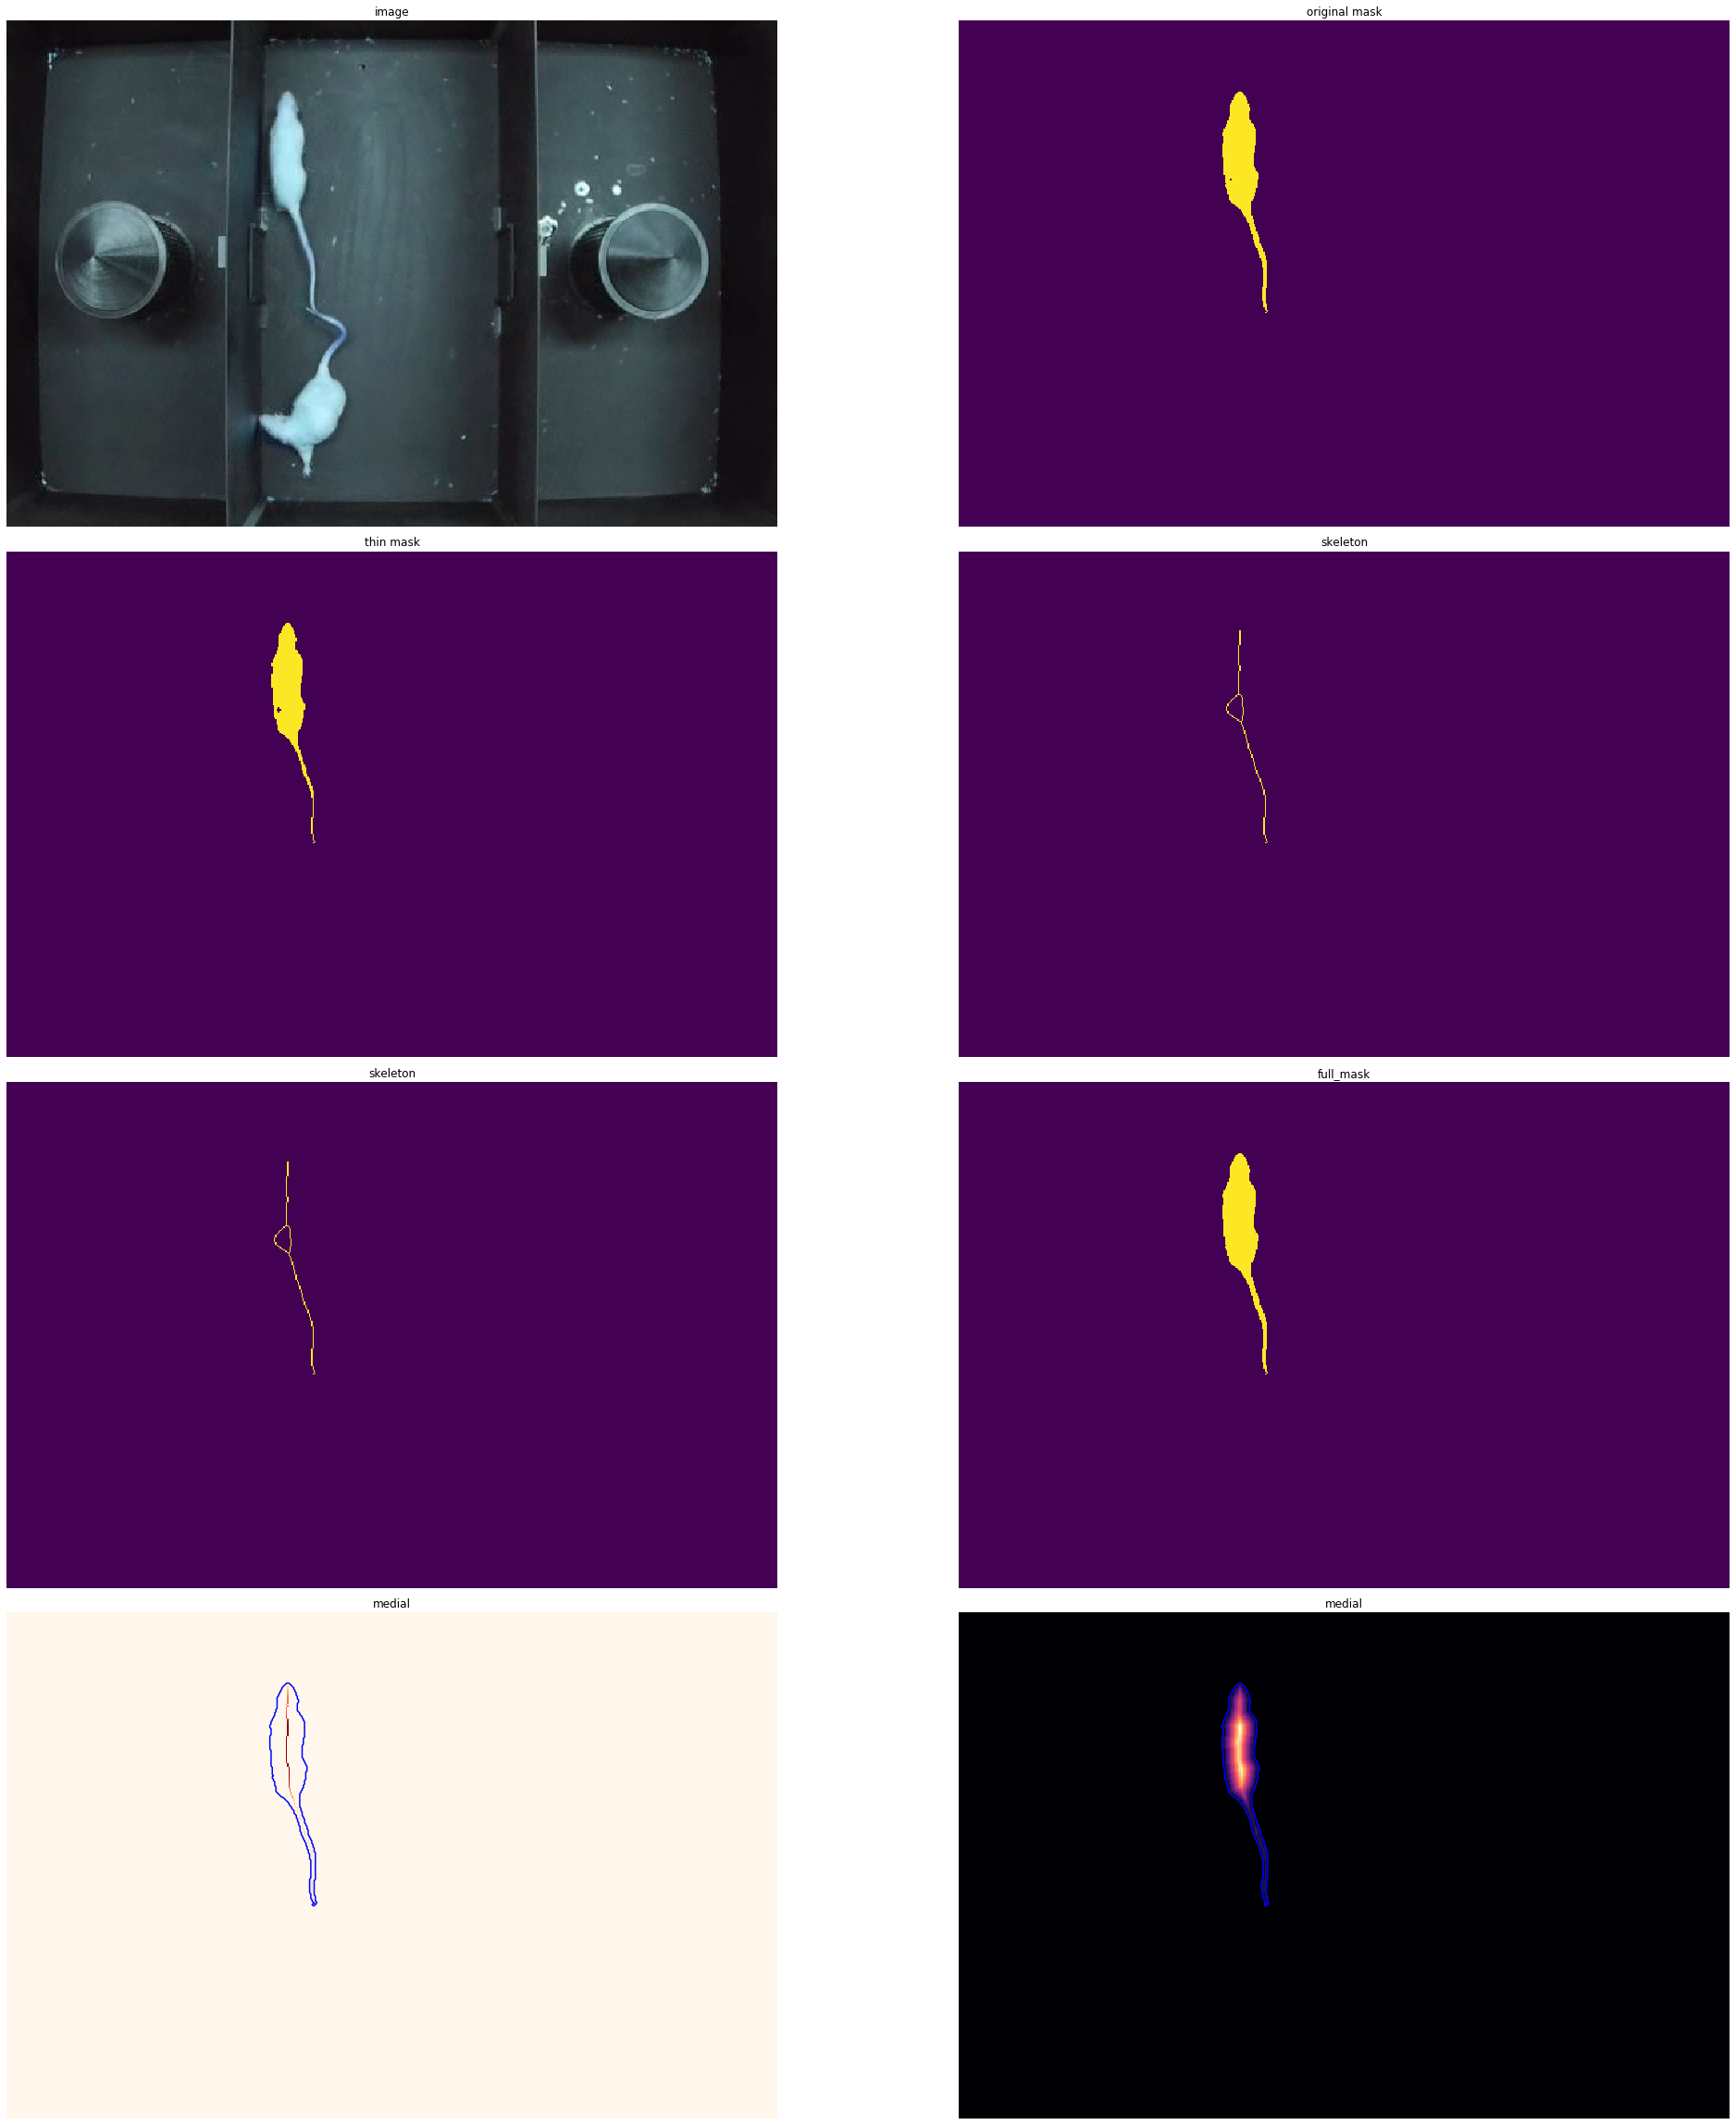

In [10]:

vid_idx = vid_idx_list[1]

video_files = zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])

inc = 0
image_filename = image_filenames[vid_idx[0] + inc]
mask_filename = mask_filenames[vid_idx[0] + inc]
bg_filename = bg_filenames[vid_idx[0] + inc]


frame_image = cv2.imread(os.path.join(image_dir, image_filename))
frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))

frame_mask[frame_mask==valid_ids[0]] = 1
frame_mask[frame_mask==valid_ids[1]] = 2

mask = (frame_mask==1).astype(np.uint8)
mask_2 = (frame_mask==2).astype(np.uint8)

print(mask.shape)



from skimage.morphology import  medial_axis, skeletonize, thin, remove_small_holes


fig, axes = plt.subplots(4, 2, figsize=(32, 32), sharex=True, sharey=True)
ax = axes.ravel()



ax[0].imshow(frame_image)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(mask)
ax[1].set_title('original mask')
ax[1].axis('off')

thinned_partial = thin(mask, max_iter=1)


ax[2].imshow(thinned_partial)
ax[2].set_title('thin mask')
ax[2].axis('off')

skeleton = skeletonize(mask)

ax[3].imshow(skeleton)
ax[3].set_title('skeleton')
ax[3].axis('off')

skeleton = skeletonize(mask, method= 'zhang')

ax[4].imshow(skeleton)
ax[4].set_title('skeleton')
ax[4].axis('off')

full_mask = remove_small_holes(mask)
full_mask_2 = remove_small_holes(mask_2)


ax[5].imshow(full_mask)
ax[5].set_title('full_mask')
ax[5].axis('off')

skel, distance = medial_axis(mask, return_distance=True)

dist_on_skel = distance * skel

cmap = plt.cm.OrRd
cmap.set_bad(color='black')

skel, distance = medial_axis(full_mask, return_distance=True)

dist_on_skel = distance * skel

#ax[6].imshow(dist_on_skel, cmap='magma')
ax[6].imshow(dist_on_skel, cmap=cmap)
ax[6].contour(full_mask, [0.1], colors='b')
ax[6].set_title('medial')
ax[6].axis('off')

skel, distance = medial_axis(full_mask, return_distance=True)

dist_on_skel = distance * skel

ax[7].imshow(distance, cmap='magma')
#ax[7].imshow(dist_on_skel, cmap=cmap)
#ax[7].imshow(skel, cmap=cmap)
ax[7].contour(full_mask, [0.1], colors='b')
ax[7].set_title('medial')
ax[7].axis('off')


fig.tight_layout()
plt.show()


In [11]:
from skimage.graph import MCP_Connect
from skimage.morphology import skeletonize
from skimage.measure import label as skimage_label
from sklearn.metrics.pairwise import euclidean_distances
from scipy.signal import convolve2d
from collections import defaultdict
import numpy as np


def find_lines(lines_mask: np.ndarray) -> list:
    """
    Finds the longest central line for each connected component in the given binary mask.
    :param lines_mask: Binary mask of the detected line-areas
    :return: a list of Opencv-style polygonal lines (each contour encoded as [N,1,2] elements where each tuple is (x,y) )
    """
    # Make sure one-pixel wide 8-connected mask
    #lines_mask = skeletonize(lines_mask)
    full_mask = remove_small_holes(lines_mask)
    lines_mask, distance = medial_axis(lines_mask, return_distance=True)

    
    if np.sum(lines_mask) == 0:
        return []
    # Find extremities points
    end_points_candidates = np.stack(np.where((convolve2d(lines_mask, np.ones((3, 3)), mode='same') == 2) & lines_mask)).T
    dist_on_skel = distance * lines_mask
    
    jump_filter = np.zeros((5, 5))
    jump_filter[0, :] = 1
    jump_filter[-1, :] = -1
    jump_filter[:, 0] = 1
    jump_filter[:, -1] = -1
    print(jump_filter)
    
    jump_points_candidates = np.stack(np.where((abs(convolve2d(dist_on_skel, jump_filter, mode='same')) > 2) & lines_mask)).T

    
    return end_points_candidates, jump_points_candidates


[[ 1.  1.  1.  1. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1.  0.  0.  0. -1.]
 [ 1. -1. -1. -1. -1.]]
[[ 61 233]
 [ 62 233]
 [ 63 233]
 [ 64 233]
 [ 65 233]
 [ 89 233]
 [ 90 233]
 [ 91 233]
 [ 92 233]
 [144 234]
 [145 234]
 [146 235]
 [147 235]
 [149 236]]
[0 1]
[ 61 233]
[242 254]
[ 61 233]
[ 62 233]
[ 63 233]
[ 64 233]
[ 65 233]
[ 89 233]
[ 90 233]
[ 91 233]
[ 92 233]
[144 234]
[145 234]
[146 235]
[147 235]
[149 236]


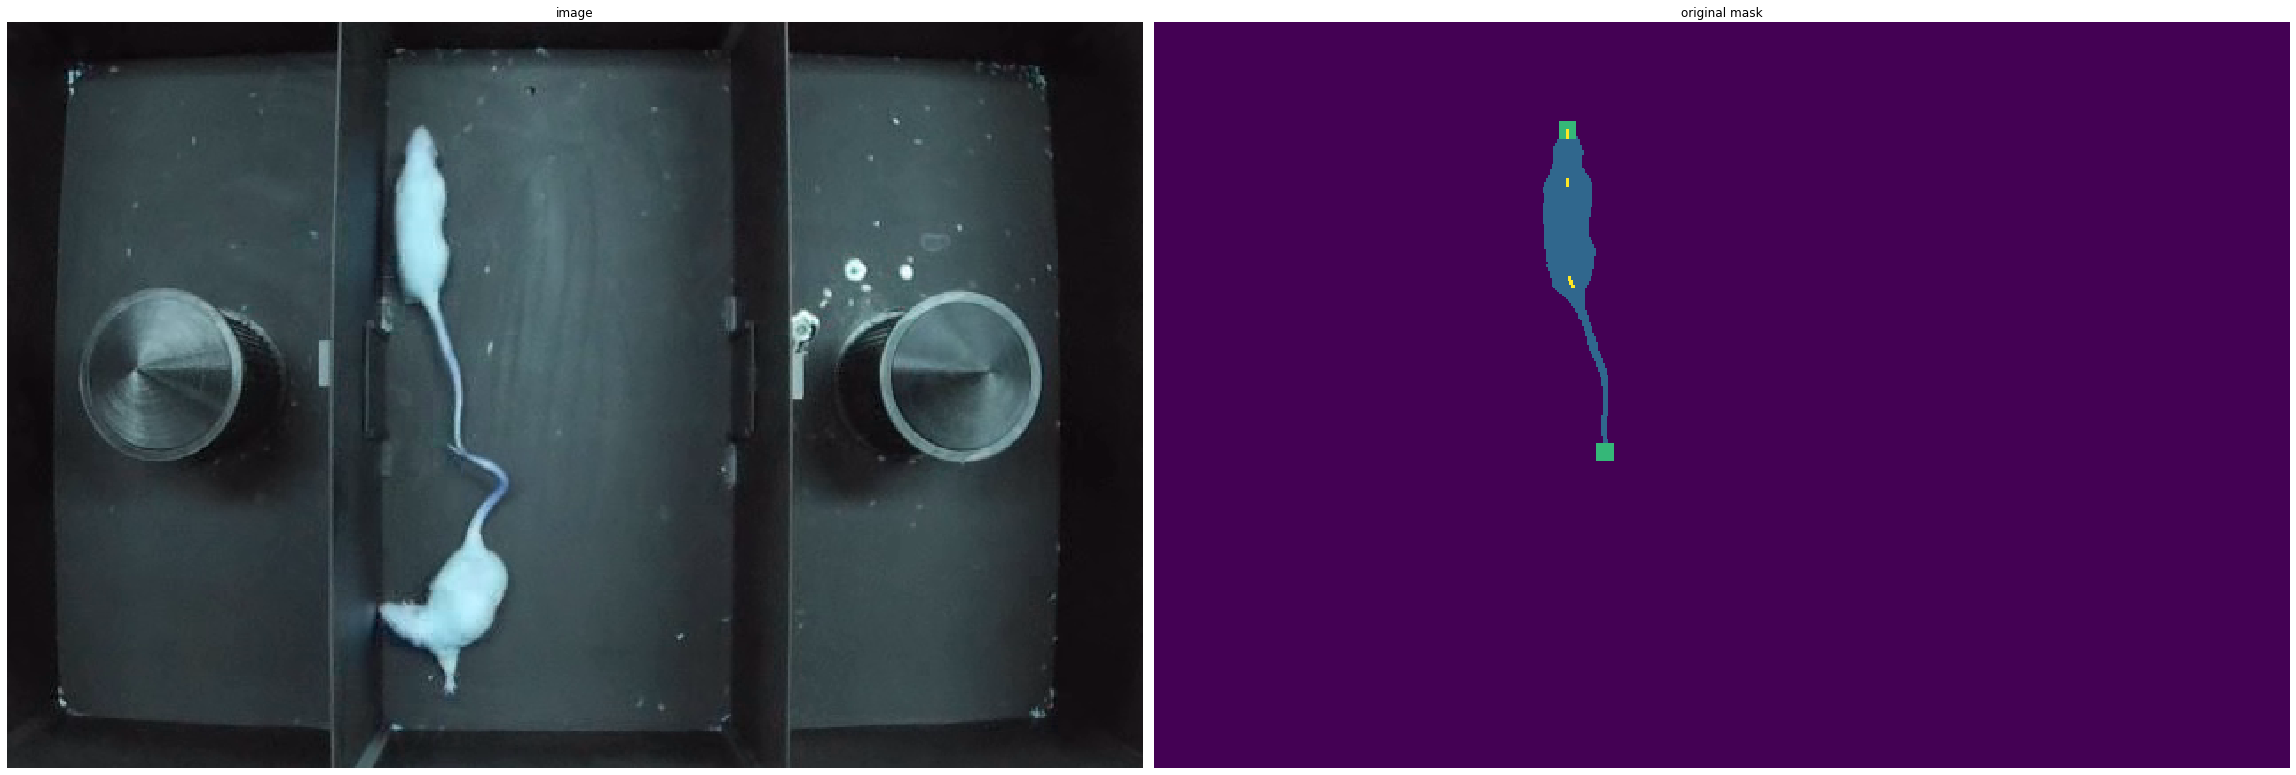

In [12]:
eps, jmp = find_lines(full_mask)
print(jmp)


fig, axes = plt.subplots(1, 2, figsize=(32, 32), sharex=True, sharey=True)
ax = axes.ravel()



ax[0].imshow(frame_image)
ax[0].set_title('image')
ax[0].axis('off')

mask_ep = full_mask.copy().astype(np.uint8)
print(np.unique(mask_ep))
for ep in eps:
    print(ep)

    mask_ep[ep[0]-5:ep[0]+5, ep[1]-5:ep[1]+5] = 2


for ep in jmp:
    print(ep)

    mask_ep[ep[0]-1:ep[0]+1, ep[1]-1:ep[1]+1] = 3

ax[1].imshow(mask_ep)
ax[1].set_title('original mask')
ax[1].axis('off')

fig.tight_layout()
plt.show()

a = 1

In [14]:
import math

def circle_sections(divisions, radius=1):
    # the difference between angles in radians -- don't bother with degrees
    angle = 2 * math.pi / divisions

    # a list of all angles using a list comprehension
    angles = [i*angle for i in range(divisions)]

    # finally return the coordinates on the circle as a list of 2-tuples
    return [(radius*math.cos(a), radius*math.sin(a)) for a in angles] 

[(15.0, 0.0), (14.265847744427303, 4.635254915624211), (12.135254915624213, 8.816778784387097), (8.816778784387097, 12.135254915624213), (4.635254915624212, 14.265847744427303), (9.18485099360515e-16, 15.0), (-4.63525491562421, 14.265847744427305), (-8.816778784387095, 12.135254915624213), (-12.13525491562421, 8.816778784387099), (-14.265847744427303, 4.635254915624213), (-15.0, 1.83697019872103e-15), (-14.265847744427305, -4.635254915624209), (-12.135254915624213, -8.816778784387095), (-8.816778784387099, -12.13525491562421), (-4.6352549156242135, -14.265847744427303), (-2.7554552980815444e-15, -15.0), (4.635254915624208, -14.265847744427305), (8.816778784387093, -12.135254915624213), (12.13525491562421, -8.8167787843871), (14.265847744427303, -4.635254915624214)]


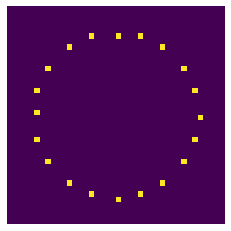

In [15]:
sections = circle_sections(20, 15)

m = np.zeros((40, 40))
center = (20, 20)

for section in sections:
    m[int(center[0]+section[0]), int(center[1]+section[1])] = 1

plt.axis('off')
plt.imshow(m)
plt.show()

In [16]:
def augment_frame(frame_image, frame_mask, frame_bg, section):
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    dilated_frame_mask = dilation(frame_mask, square(15))    
    
    center_rat_1 = ndimage.measurements.center_of_mass(frame_mask==1)
    center_rat_2 = ndimage.measurements.center_of_mass(frame_mask==2)    
    move =  (int(center_rat_2[0] - center_rat_1[0] + section[0]),
             int(center_rat_2[1] - center_rat_1[1] + section[1]))
    
    
    
    moved_mask = (frame_mask==1)    
    whr0, whr1 = np.where(moved_mask)   
    
    if (move[0] + max(whr0) + 1) > moved_mask.shape[0]:
        d = min(0, moved_mask.shape[0] - (move[0] + max(whr0) + 1))
    elif (move[0] + min(whr0)) < 0:
        d = max(0, -(move[0] + min(whr0)))
    else:
        d = 0
     
    
    move = (move[0] + d, move[1])    
    whr0 = whr0 + move[0]
    whr1 = whr1 + move[1]
    
    assert max(whr0) < moved_mask.shape[0]
    assert min(whr0) >= 0
    
    moved_mask[...] = 0    
    moved_mask[whr0, whr1] = 1
    
    #ax[0].imshow(frame_image)
    #ax[1].imshow(frame_mask)
    
    new_mask = np.zeros_like(frame_mask)
    
    new_mask[frame_mask==2] = 2
    new_mask[moved_mask==1] = 1 
    #ax[2].imshow(new_mask)
    
    dilated_one_rat_image = frame_image.copy()    
    dilated_one_rat_image[dilated_frame_mask==1] = frame_bg[dilated_frame_mask==1]  
    dilated_one_rat_image[moved_mask==1] = frame_image[frame_mask==1]
    
    #### blur
    blurred_img = cv2.GaussianBlur(dilated_one_rat_image, (9, 9), 0)
    blur_moved_mask = moved_mask.copy().astype(np.uint8)
    #blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    contours, hierarchy = cv2.findContours(blur_moved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(blur_moved_mask, contours, -1, (2),2)
    blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    dilated_one_rat_image = np.where(blur_moved_mask==np.array([2, 2, 2]), blurred_img, dilated_one_rat_image)
    
    return new_mask, dilated_one_rat_image

In [22]:
def coco_segm(gt_mask):
    ground_truth_binary_mask = gt_mask.astype(np.uint8)
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_mask = cocomask.encode(fortran_ground_truth_binary_mask)

    area = cocomask.area(encoded_mask)
    bounding_box = cocomask.toBbox(encoded_mask)
    encoded_mask['counts'] = encoded_mask['counts'].decode('ascii')
    
    return encoded_mask, area.tolist(), bounding_box.tolist()
    

In [35]:
rat_info = dict(description= 'Rats', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
rat_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
rat_categories = [dict(supercategory= 'object', id= 1, name ='rat')]


def annotation_data(vid_idx_list, video_dir, video_mask_dir, augment=True):
    valid_ids = [127, 255]
   
    rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    videos=[],
                    annotations=[])


    ann_id = 1
    for v, vid_idx in enumerate(vid_idx_list):

        vid_id = (v*5) + 1

        video = dict(width= 640,
                     length= vid_idx[1]-vid_idx[0],
                     date_captured= '',
                     license= '',
                     flickr_url= '',
                     file_names= [],
                     id= vid_id,
                     coco_url= '',
                     height=420)  

        ann_rat_1 = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= ann_id,
                         areas= [])

        ann_id += 1

        ann_rat_2 = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= ann_id,
                         areas= [])

        ann_id += 1

        vid_path = os.path.join(video_dir, str(vid_id))
        if not os.path.exists(vid_path):
            os.mkdir(vid_path)
        vid_mask_path=os.path.join(video_mask_dir, str(vid_id))
        if not os.path.exists(vid_mask_path):
            os.mkdir(vid_mask_path)



        video_files = zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])

        for f, (image_filename, mask_filename, bg_filename) in enumerate(video_files): 
            frame_image = cv2.imread(os.path.join(image_dir, image_filename))
            frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
            frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))


            video['file_names'].append(os.path.join(str(vid_id), '{}.png'.format(f)))

            encoded_mask1, area1, bbox1 = coco_segm((frame_mask==valid_ids[0]).astype(np.uint8))
            ann_rat_1['segmentations'].append(encoded_mask1)
            ann_rat_1['bboxes'].append(bbox1)
            ann_rat_1['areas'].append(area1)

            encoded_mask2, area2, bbox2 = coco_segm((frame_mask==valid_ids[1]).astype(np.uint8))
            ann_rat_2['segmentations'].append(encoded_mask2)
            ann_rat_2['bboxes'].append(bbox2)
            ann_rat_2['areas'].append(area2)       


            cv2.imwrite(os.path.join(vid_path, '{}.png'.format(f)), frame_image)
            cv2.imwrite(os.path.join(vid_mask_path, '{}.png'.format(f)), frame_mask)       

        rat_data['videos'].append(video)
        rat_data['annotations'].append(ann_rat_1)
        rat_data['annotations'].append(ann_rat_2)

        ### AUGMENT
        if augment:
            aug_vid_id = vid_id + 1
            for rad in [1, 20, 40, 80]:

                aug_video = dict(width= 640,
                             length= vid_idx[1]-vid_idx[0],
                             date_captured= '',
                             license= '',
                             flickr_url= '',
                             file_names= [],
                             id= aug_vid_id,
                             coco_url= '',
                             height=420)

                aug_ann_rat_1 = dict(height= 420,
                                 width= 640,
                                 length= 1,
                                 category_id= 1,
                                 segmentations= [],
                                 bboxes= [],
                                 video_id= aug_vid_id,
                                 iscrowd= False,
                                 id= ann_id,
                                 areas= [])
                ann_id += 1

                aug_ann_rat_2 = dict(height= 420,
                                 width= 640,
                                 length= 1,
                                 category_id= 1,
                                 segmentations= [],
                                 bboxes= [],
                                 video_id= aug_vid_id,
                                 iscrowd= False,
                                 id= ann_id,
                                 areas= [])
                ann_id += 1

                aug_vid_path = os.path.join(video_dir, 'aug_{}'.format(aug_vid_id))
                if not os.path.exists(aug_vid_path):
                    os.mkdir(aug_vid_path)
                aug_vid_mask_path=os.path.join(video_mask_dir, 'aug_{}'.format(aug_vid_id))
                if not os.path.exists(aug_vid_mask_path):
                    os.mkdir(aug_vid_mask_path)


                video_files = zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])

                sections = circle_sections(rad, rad)
                for f, (image_filename, mask_filename, bg_filename) in enumerate(video_files):   
                    frame_image = cv2.imread(os.path.join(image_dir, image_filename))
                    frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
                    frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))
                    section = sections[f%len(sections)]
                    new_mask, dilated_one_rat_image = augment_frame(frame_image, frame_mask, frame_bg, section)

                    encoded_mask, area, bbox = coco_segm(new_mask==1)
                    aug_ann_rat_1['segmentations'].append(encoded_mask)
                    aug_ann_rat_1['bboxes'].append(bbox)
                    aug_ann_rat_1['areas'].append(area)

                    encoded_mask, area, bbox = coco_segm(new_mask==2)
                    aug_ann_rat_2['segmentations'].append(encoded_mask)
                    aug_ann_rat_2['bboxes'].append(bbox)
                    aug_ann_rat_2['areas'].append(area)

                    new_mask[new_mask==1] = valid_ids[0]
                    new_mask[new_mask==2] = valid_ids[1]

                    aug_video['file_names'].append(os.path.join('aug_{}'.format(aug_vid_id), '{}.png'.format(f)))
                    cv2.imwrite(os.path.join(aug_vid_path, '{}.png'.format(f)), dilated_one_rat_image)
                    cv2.imwrite(os.path.join(aug_vid_mask_path, '{}.png'.format(f)), new_mask)


                #print('xxxx')
                rat_data['videos'].append(aug_video)    

                rat_data['annotations'].append(aug_ann_rat_1)
                rat_data['annotations'].append(aug_ann_rat_2)
                aug_vid_id += 1

                valid_ids = valid_ids[::-1]
            
    return rat_data

def test_video_data(vid_idx, video_dir, vid_length=200):
    rat_data = dict(info=rat_info, 
                    licenses=rat_licenses,
                    categories=rat_categories,
                    videos=[],
                    annotations=[])

    for vid_id, frame_idx in enumerate(list(range(vid_idx, len(image_filenames), vid_length))):
        video = dict(width= 640,
                     length= min(100, len(image_filenames)-frame_idx),
                     date_captured= '',
                     license= '',
                     flickr_url= '',
                     file_names= [],
                     id= vid_id,
                     coco_url= '',
                     height=420) 

        vid_path = os.path.join(video_dir, str(vid_id))
        if not os.path.exists(vid_path):
            os.mkdir(vid_path)
        for f, image_filename in enumerate(image_filenames[frame_idx:frame_idx+min(vid_length, len(image_filenames)-frame_idx)]):
            frame_image = cv2.imread(os.path.join(image_dir, image_filename))    

            video['file_names'].append(os.path.join(str(vid_id), '{}.png'.format(f)))
            cv2.imwrite(os.path.join(vid_path, '{}.png'.format(f)), frame_image)      

        rat_data['videos'].append(video)
    
    ann_rat_test = dict(height= 420,
                         width= 640,
                         length= 1,
                         category_id= 1,
                         segmentations= [],
                         bboxes= [],
                         video_id= vid_id,
                         iscrowd= False,
                         id= 0,
                         areas= [])
    rat_data['annotations'].append(ann_rat_test)
    
    return rat_data
    

In [36]:
if not os.path.exists(video_dir):
    os.mkdir(video_dir)
    
if not os.path.exists(video_mask_dir):
    os.mkdir(video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[:100], video_dir, video_mask_dir)

with open('/home/fothar/rats/annotations/instances_train.json', 'w') as outfile:
    json.dump(ann_data, outfile)
    
if not os.path.exists(val_video_dir):
    os.mkdir(val_video_dir)
    
if not os.path.exists(val_video_mask_dir):
    os.mkdir(val_video_mask_dir)
    
ann_data = annotation_data(vid_idx_list[100:], val_video_dir, val_video_mask_dir)

with open('/home/fothar/rats/annotations/instances_val.json', 'w') as outfile:
    json.dump(ann_data, outfile)


2 1
3 20
4 40
5 80
7 1
8 20
9 40
10 80
12 1
13 20
14 40
15 80
17 1
18 20
19 40
20 80
22 1
23 20
24 40
25 80
27 1
28 20
29 40
30 80
32 1
33 20
34 40
35 80
37 1
38 20
39 40
40 80
42 1
43 20
44 40
45 80
47 1
48 20
49 40
50 80
52 1
53 20
54 40
55 80
57 1
58 20
59 40
60 80
62 1
63 20
64 40
65 80
67 1
68 20
69 40
70 80
72 1
73 20
74 40
75 80
77 1
78 20
79 40
80 80
82 1
83 20
84 40
85 80
87 1
88 20
89 40
90 80
92 1
93 20
94 40
95 80
97 1
98 20
99 40
100 80
102 1
103 20
104 40
105 80
107 1
108 20
109 40
110 80
112 1
113 20
114 40
115 80
117 1
118 20
119 40
120 80
122 1
123 20
124 40
125 80
127 1
128 20
129 40
130 80
132 1
133 20
134 40
135 80
137 1
138 20
139 40
140 80
142 1
143 20
144 40
145 80
147 1
148 20
149 40
150 80
152 1
153 20
154 40
155 80
157 1
158 20
159 40
160 80
162 1
163 20
164 40
165 80
167 1
168 20
169 40
170 80
172 1
173 20
174 40
175 80
177 1
178 20
179 40
180 80
182 1
183 20
184 40
185 80
187 1
188 20
189 40
190 80
192 1
193 20
194 40
195 80
197 1
198 20
199 40
200 80
202 1


In [ ]:


if not os.path.exists(test_video_dir):
    os.mkdir(test_video_dir)
    
test_data = test_video_data(vid_idx_list[0][0], test_video_dir)

with open('/home/fothar/rats/annotations/instances_test.json', 'w') as outfile:
    json.dump(test_data, outfile)

## Test

In [37]:
from mmdet.datasets import build_dataset

from mmdet.datasets.rats import RatsDataset

In [38]:
dataset_type = 'RatsDataset'
data_root = '/home/fothar/rats/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

        
yt_data = RatsDataset(ann_file=data_root + 'annotations/instances_train.json',
        img_prefix=data_root + 'videos',
        img_scale=(640, 420),
        img_norm_cfg=img_norm_cfg,
        size_divisor=32,
        flip_ratio=0.5,
        with_mask=True,
        with_crowd=True,
        with_label=True,
        with_track=True)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [65]:
xx = yt_data.__getitem__(142)

In [66]:
xx.keys()

dict_keys(['img', 'img_meta', 'gt_bboxes', 'gt_labels', 'obj_ids', 'gt_bboxes_ignore', 'gt_masks'])

In [67]:
np.unique(xx['gt_labels'].data)

array([1])

In [68]:
np.unique(xx['obj_ids'].data)

array([3, 4])

In [52]:
mask = xx['gt_masks'].data
mask.shape

(2, 448, 640)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


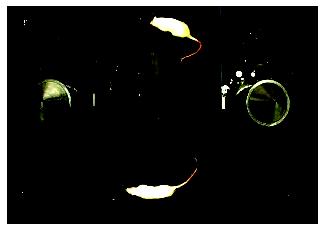

In [43]:
I = xx['img'].data.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(I)
plt.show()

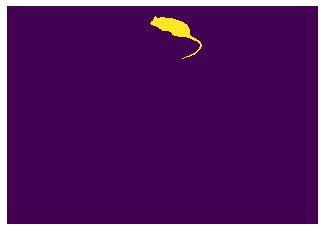

In [44]:
plt.axis('off')
plt.imshow(mask[0])
plt.show()

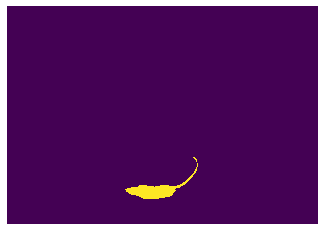

In [45]:
plt.axis('off')
plt.imshow(mask[1])
plt.show()

In [ ]:
2+3

In [ ]:
c = 0
for i in range (4):
    c += len(rat_data['videos'][i]['file_names'])

c


In [ ]:


cap = cv2.VideoCapture('/home/fothar/rats/rat_sepbg_fr20to15020.avi')

test_video_dir = '/home/fothar/rats/test_videos'

test_info = dict(description= 'Rats test', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
test_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
test_categories = [dict(supercategory= 'object', id= 1, name ='rat')]
test_data = dict(info=test_info, 
                licenses=test_licenses,
                categories=test_categories,
                videos=[],
                annotations=[])



vid_frames = []
frame_id = 1
video_id = 1
while(cap.isOpened()):
    
    if frame_id % 5 ==0:
        video = dict(width= 640,
                 length= len(vid_frame),
                 date_captured= '',
                 license= '',
                 flickr_url= '',
                 file_names= [],
                 id= video_id,
                 coco_url= '',
                 height=420)
        
        test_vid_path = os.path.join(test_video_dir, '{}'.format(video_id))
        if not os.path.exists(test_vid_path):
            os.mkdir(test_vid_path)
        for f, vid_frame in enumerate(vid_frames):
            cv2.imwrite(os.path.join(test_vid_path, '{}_{}.png'.format(f, video_id)), vid_frame)
            video['file_names'].append(os.path.join('{}'.format(video_id), '{}_{}.png'.format(f, video_id)))
        
        test_data['videos'].append(video)        
        vid_frames = vid_frames[-1:]
        video_id += 1
    
    ret, frame = cap.read()    
    if ret:
        
        vid_frames.append(frame[:420, :640])
        
        frame_id += 1
    else:
        break

cap.release()

with open('/home/fothar/rats/annotations/instances_test.json', 'w') as outfile:
    json.dump(test_data, outfile)